In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [7]:
# MNIST DATA Download & train test split
# root 저장될 공간, train 훈련데이터 여부, download 다운로드 여부, transform 다운과 동시에 데이터 전처리 가능
# transforms.ToTensor() torch모델로 집어넣기 때문에 torch.Tensor로 변환시켜주고, 
# 동시에 너무 큰 값을 갖는 데이터는 불안정하거나 과적합되는 방향으로 진행될 가능성이 있기때문에 0~1사이의 값을 갖는 정규화 진행
train_dataset = datasets.MNIST(root = './Data/MNIST',train = True,download = True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root = './Data/MNIST',train = False,download = True, transform=transforms.ToTensor())

# 다운로드한 dataset들을 배치사이즈로 분리해 지정한다. 즉, 배치사이즈 만큼의 미니배치를 구성하는 것을 DataLoader를 통해 할 수 있다.
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [17]:
for (x_train,y_train) in train_loader:
    print(x_train.size())
    print(y_train.size())
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [18]:
# 데이터 확인해보기
for (x_train,y_train) in train_loader:
    print('X_train : ',x_train.size(), ' type : ',x_train.type())
    print('y_train : ',y_train.size(), ' type : ',y_train.type())
    break

X_train :  torch.Size([32, 1, 28, 28])  type :  torch.FloatTensor
y_train :  torch.Size([32])  type :  torch.LongTensor


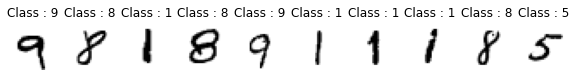

In [23]:
# 데이터 확인해보기 (2)
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28), cmap = 'gray_r')
    plt.title('Class : ' + str(y_train[i].item()))

In [24]:
# MLP 모델 설계하기
class MNIST_Model(nn.Module):
    def __init__(self):
        # nn.Module의 메소드 상속
        super(MNIST_Model,self).__init__()
        self.fc1 = nn.Linear(28*28,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,10)
    
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        # torch model 설계에 유용한 함수들을 모아놓은 torch.nn.functional
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [31]:
# model 을 cuda 에 할당
model = MNIST_Model().to(DEVICE)
# loss값들을 최소화하는 방법으로 SGD를 선택했고, 가중치를 업데이트하는 것은 model.parameters(), 학습률은 0.01, 옵티마이저 관성 : 0.5로 설정
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01, momentum=0.5)
# 원핫인코딩
criterion = nn.CrossEntropyLoss()

print(model)

MNIST_Model(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [32]:
# MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
    # 기존에 정의한 모델을 학습상태로 지정
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader):
        # 기존에 정의한 장비에 할당
        image = image.to(DEVICE)
        label = label.to(DEVICE)

        # 기존에 정의한 장비에 이미지 데이터와 레이블 데이터를 할당할 경우, 과거에 이용한 loss의 gradient가 optimizer에 할당되어 있으므로 초기화
        optimizer.zero_grad()

        # 장비에 할당한 이미지 데이터를 MLP 모델의 Input값으로 넣어 예측
        output = model(image)

        # 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 Loss값을 계산
        loss = criterion(output,label)

        # loss값을 계산한 결과를 바탕으로 Back Propagation 을 통해 계산된 Gradient 값을 각 파라미터에 할당
        loss.backward()

        # 각 파라미터에 할당된 Gradient값을 이용해 파라미터 값을 업데이트한다.
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch : {} [{}/{} ({:.0f}%)]\t Train Loss : {:.6f}".format(Epoch,batch_idx*len(image),len(train_loader.dataset),100. * batch_idx / len(train_loader),loss.item()))


In [33]:
# 검증 데이터에 대한 모델 성능을 확인하는 함수
def evaluate(model,test_loader):
    # 이미 학습이 완료가 된 모델에 대해 더 이상 학습을 통해 파라미터가 진행되는 상태가 아닌, 평가 상태로 지정
    model.eval()

    # test_loss 값을 계산하기 위해 초기화
    test_loss = 0
    # 올바르게 분류한 경우를 세기 위해 correct 변수 초기화
    correct = 0
    
    # gradient를 통해 파라미터 값이 업데이트되는 현상을 방지하기 위해 torch.no_grad를 사용해 흐름을 억제한다.
    with torch.no_grad():
        # test image , label를 뽑아냄
        for image, label in test_loader:
            # 이미지, 라벨을 cuda 에 할당
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            # image를 모델에 넣어 예측 > 결과값
            output = model(image)

            # crossentropy 객체에 output값과 라벨 값을 넣어주고 test_loss에 더해준다.
            test_loss += criterion(output,label).item()

            # 결과값은 크기가 10인 벡터값이니 가장 큰값의 위치에 대해 대응하는 클래스로 예측했다고 판단
            prediction = output.max(1, keepdim = True)[1]

            # 예측값과 실제 라벨값이 일치하게 되면 correct에 더해준다.
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    # test_loss 의 값을 데이터 크기 만큼 나눠서 평균값을 구한다.
    test_loss /= len(test_loader.dataset)
    # 데이터 크기 만큼 나눠 평균값을 구한다.
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [34]:
## MLP 학습을 실행하면서 Train, Test_set 의 Loss 및 Test set Accuracy 를 확인하기
for Epoch in range(1,EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model,test_loader)
    print("\[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/60000 (0%)]	 Train Loss : 2.352414
Train Epoch : 1 [6400/60000 (11%)]	 Train Loss : 2.259543
Train Epoch : 1 [12800/60000 (21%)]	 Train Loss : 2.291816
Train Epoch : 1 [19200/60000 (32%)]	 Train Loss : 2.289183
Train Epoch : 1 [25600/60000 (43%)]	 Train Loss : 2.310908
Train Epoch : 1 [32000/60000 (53%)]	 Train Loss : 2.279367
Train Epoch : 1 [38400/60000 (64%)]	 Train Loss : 2.297324
Train Epoch : 1 [44800/60000 (75%)]	 Train Loss : 2.284940
Train Epoch : 1 [51200/60000 (85%)]	 Train Loss : 2.299412
Train Epoch : 1 [57600/60000 (96%)]	 Train Loss : 2.277715
\[EPOCH : 1], 	Test Loss : 0.0696, 	Test Accuracy : 28.62 %

Train Epoch : 2 [0/60000 (0%)]	 Train Loss : 2.208535
Train Epoch : 2 [6400/60000 (11%)]	 Train Loss : 2.205148
Train Epoch : 2 [12800/60000 (21%)]	 Train Loss : 2.173249
Train Epoch : 2 [19200/60000 (32%)]	 Train Loss : 2.133495
Train Epoch : 2 [25600/60000 (43%)]	 Train Loss : 2.042274
Train Epoch : 2 [32000/60000 (53%)]	 Train Loss : 1.924998
Train E